## Import Library
Pada tahap ini, import library antara lain pandas, sklearn, sastrawi dan nltk

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB ; import collections
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stopword_factory = StopWordRemoverFactory()
stopwordsSastrawi = stopword_factory.get_stop_words()
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Tahap 1, Membaca Dataset
Dataset berikut sudah dilakukan pelabelan secara manual menggunakan Microsoft Excel, dataset ini berisi hasil  crawling dari konten instagram dan youtube, selanjutnya kita akan menggunakan hanya kolom komentar dan klasifikasi

In [2]:
# Membaca dataset
df = pd.read_csv('DATA FIX.csv', encoding='latin-1', on_bad_lines='skip')
print('Dataset')
display(df.head())
# Memisahkan fitur (komentar) dan label (klasifikasi)
X = df['Komentar']
Y = df['Klasifikasi']

Dataset


,Komentar,Klasifikasi
0,Iya min cuaca lagi ga enak lagi batuk filek?,NEGATIF
1,Apa kabar JALAN protokol KESEHATAN?,NETRAL
2,Pada jahat nih orang orang cari uangnya ngga b...,NEGATIF
3,"Lagi intens bgt nih, tiba tiba hujan bentar tr...",NEGATIF
4,"Lampung mulai nih ,ada pesawat capung keliling...",NEGATIF


## Tahap 2, Preprocessing
Preprocessing mencakup Cleansing, Case Folding, Stopwords Removal menggunakan Sastrawi, Stemming, dan Tokenizing

Tahap 2.1 Cleansing

In [3]:
def cleansing(text):
    #hapus url
    text = re.sub(r'http\S+|www\S+|https\S+', '', str(text))
    #hapus '@' username
    text = re.sub('@[^\s]+', ' ', text)
    #hapus dobel spasi
    text = re.sub(r'[^\w\s]+', '', text)
    text = re.sub(r'\s+', ' ', text)
    #hapus angka
    text = re.sub('[0-9]+', '', text)
    #hapus special char
    text = re.sub(r"[.,:;+!\-_<^/=?\"'\(\)\d\*]", " ", text)

    return text

df['cleansing'] = df['Komentar'].apply(lambda text: cleansing(text))
df['cleansing'].head()
df.dropna()
df['cleansing']
# df['cleansing'].to_csv('preproces.csv')

0

Tahap 2.2 Case Folding

In [4]:
df['casefolding'] = df['cleansing'].str.lower()
df['casefolding']

0             iya min cuaca lagi ga enak lagi batuk filek
1                      apa kabar jalan protokol kesehatan
2       pada jahat nih orang orang cari uangnya ngga b...
3       lagi intens bgt nih tiba tiba hujan bentar tru...
4       lampung mulai nih ada pesawat capung keliling ...
                              ...                        
2081    menyadari bahwa chemtrails adalah sebuah hoax ...
2082    secara ilmiah chemtrails sebenarnya adalah con...
2083    contrails yang terlihat di langit adalah bukti...
2084    chemtrails itu bukan virus yg sengaja disebar ...
2085    chemtrail tidak berhubungan dengan penyebaran ...
Name: casefolding, Length: 2086, dtype: object

Tahap 2.3 Stopwords Removal

In [5]:
stopwordsFromNltk = set(stopwords.words('indonesian'))
stopwordsList = stopwordsFromNltk.union(stopwordsSastrawi)
stopwordsFix = set(stopwordsList)

df['stopwords'] = df['casefolding'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwordsFix)]))
df['stopwords']

0                       iya min cuaca ga enak batuk filek
1                          kabar jalan protokol kesehatan
2                 jahat nih orang orang cari uangnya ngga
3       intens bgt nih hujan bentar trus panas racun s...
4       lampung nih pesawat capung keliling gak perkeb...
                              ...                        
2081    menyadari chemtrails hoax membantu membedakan ...
2082    ilmiah chemtrails contrail kontrail terbentuk ...
2083    contrails langit bukti keberadaan pesawat jeja...
2084    chemtrails virus yg sengaja disebar contrail j...
2085    chemtrail berhubungan penyebaran virus klaim m...
Name: stopwords, Length: 2086, dtype: object

Tahap 2.4 Stemming

In [6]:
def stemming(text):
    stemmer = StemmerFactory().create_stemmer()
    text = stemmer.stem(text)

    return text

df['stemming'] = df['stopwords'].apply(stemming)
df['stemming']

0                       iya min cuaca ga enak batuk filek
1                              kabar jalan protokol sehat
2                    jahat nih orang orang cari uang ngga
3       intens bgt nih hujan bentar trus panas racun s...
4       lampung nih pesawat capung keliling gak kebun ...
                              ...                        
2081    sadar chemtrails hoax bantu beda ilmu tahu val...
2082    ilmiah chemtrails contrail kontrail bentuk uap...
2083    contrails langit bukti ada pesawat jejak aktiv...
2084    chemtrails virus yg sengaja sebar contrail jej...
2085    chemtrail hubung sebar virus klaim milik dasar...
Name: stemming, Length: 2086, dtype: object

Tahap 2.5 Tokenizing

In [7]:
def tokenize(token):
    tokenizer = word_tokenize(token)
    token = tokenizer
    return token

df['tokenizing'] = df['stemming'].apply(lambda token: tokenize(token))
df['tokenizing'] 

0               [iya, min, cuaca, ga, enak, batuk, filek]
1                         [kabar, jalan, protokol, sehat]
2            [jahat, nih, orang, orang, cari, uang, ngga]
3       [intens, bgt, nih, hujan, bentar, trus, panas,...
4       [lampung, nih, pesawat, capung, keliling, gak,...
                              ...                        
2081    [sadar, chemtrails, hoax, bantu, beda, ilmu, t...
2082    [ilmiah, chemtrails, contrail, kontrail, bentu...
2083    [contrails, langit, bukti, ada, pesawat, jejak...
2084    [chemtrails, virus, yg, sengaja, sebar, contra...
2085    [chemtrail, hubung, sebar, virus, klaim, milik...
Name: tokenizing, Length: 2086, dtype: object

Tahap 2.6 Normalization

In [8]:
normalizedWordList = pd.read_csv('colloquial-indonesian-lexicon.csv')
normalizedWordDict = {}

for index, row in normalizedWordList.iterrows():
    if row[0] not in normalizedWordList:
        normalizedWordDict[row[0]] = row[1]
def normalized_term(document):
 return [normalizedWordDict[term] if term in normalizedWordDict
else
term for term in document]

df['normalize'] = df['tokenizing'].apply(normalized_term)
df['normalize'] = [' '.join(text_list) for text_list in df['normalize']]
df['normalize']


0                   iya min cuaca enggak enak batuk filek
1                              kabar jalan protokol sehat
2                  jahat nih orang orang cari uang enggak
3       intens banget nih hujan bentar terus panas rac...
4       lampung nih pesawat capung keliling enggak keb...
                              ...                        
2081    sadar chemtrails hoax bantu beda ilmu tahu val...
2082    ilmiah chemtrails contrail kontrail bentuk uap...
2083    contrails langit bukti ada pesawat jejak aktiv...
2084    chemtrails virus yang sengaja sebar contrail j...
2085    chemtrail hubung sebar virus klaim milik dasar...
Name: normalize, Length: 2086, dtype: object

Visualisasi

<Axes: xlabel='Klasifikasi', ylabel='Count'>

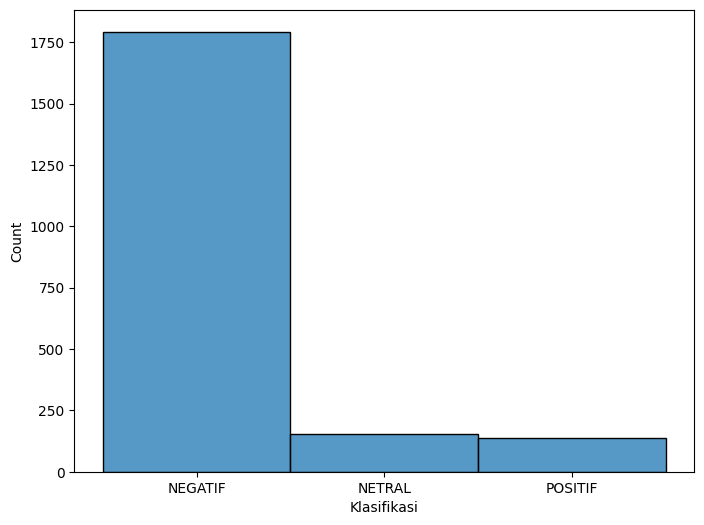

In [9]:
fig = plt.figure(figsize=(8,6))

sns.histplot(data=df, x='Klasifikasi')

## Tahap 3, Pembobotan TF-IDF
Pada tahap ini menggunakan fungsi tfidfvectorizer dari library sklearn, tentu sebelum itu dilakukan perlu melakukan split data dengan pembagian 80% data training dan 20% data testing

In [10]:
# Membagi dataset menjadi data latih dan data uji
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Membuat representasi vektor dari fitur menggunakan TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train).toarray()
# Y_train = vectorizer.fit_transform(Y_train).toarray()
np.shape(Y_train)
X_train
# vectorizer.fit(X_train.values.ravel())
# X_train=vectorizer.fit_transform(X_train.values.ravel())
# X_test=vectorizer.fit_transform(X_test.values.ravel())
# X_train=X_train.toarray()
# X_test=X_test.toarray()
# print("\nRepresentasi vektor fitur:")
# print(X_train)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
X_smote, Y_smote = SMOTE().fit_resample(X_train, Y_train)
np.shape(Y_smote)

TypeError: '<' not supported between instances of 'float' and 'str'

In [ ]:
fig = plt.figure(figsize=(8,6))

sns.histplot(data=Y_smote)

In [ ]:
model = MultinomialNB()
model.fit(X_smote, Y_smote)

In [ ]:
# Melakukan transformasi pada data uji
X_test_vect = vectorizer.transform(df['normalize'])

# Melakukan prediksi pada data uji
y_pred = model.predict(X_test_vect)

In [ ]:
datatest = ['racun terus', 'Kalo berbusa kenapa min ? Keanehan kah ?', 'pemerintah lagi berusaha']
datatestVectorized = vectorizer.transform(datatest)

model.predict(datatestVectorized)

In [ ]:
report = classification_report(Y_test, y_pred, zero_division=0)
# accuracy = (y_pred == y_test).mean()
# accuracy_df = pd.DataFrame([accuracy], columns=["Akurasi"])
# print("\nAkurasi:")
print("Hasil Evaluasi Model:")
print(report)

## Tahap 4, SMOTE(Synthetic Minority Oversampling Technique)

In [ ]:
#sm = SMOTE(random_state=30, sampling_strategy='minority')
#X_train_array = X_train_vect.toarray()
#Y_train_array = Y_train_vect.toarray()

#x_sampling, y_sampling = sm.fit_resample(X_train_array, Y_train_array)

#print(len(x_sampling))
#print(len(y_sampling))

In [ ]:
x_train = pd.DataFrame(X_train)
X_resample, Y_resampled = SMOTE().fit_resample(X_train, Y_train)

In [ ]:
fig = plt.figure(figsize=(8,6))

sns.histplot(data=Y_resampled)

## Tahap 5, Implementasi / Pemodelan Naive Bayes
Pada tahap ini menggunakan fungsi MultinomialNB() dari sklearn

In [ ]:
# Melatih model klasifikasi Naïve Bayes
model = MultinomialNB()
model.fit(X_train, Y_train)

## Tahap 6, Melakukan Prediksi
Pada tahap ini melakukan prediksi dengan model data latih yang sudah diproses sebelumnya

In [ ]:
# Melakukan transformasi pada data uji
X_test_vect = vectorizer.transform(df['normalize'])

# Melakukan prediksi pada data uji
y_pred = model.predict(X_test_vect)
#y_pred.tolist().index('NETRAL')

# X_test[y_pred!=y_test]


Tahap 6.1 Data Test

In [ ]:
datatest = ['chemtrail mulu bahasnya', 'Kalo berbusa kenapa min ? Keanehan kah ?', 'Kualitas udara Sebab dan akibat']
datatestVectorized = vectorizer.transform(datatest)

model.predict(datatestVectorized)


## Tahap 7, Evaluasi Model
Pada tahap ini menggunakan sklearn.matrix

In [ ]:
# Evaluasi performa model
report = classification_report(Y_test, y_pred, zero_division=0)
# accuracy = (y_pred == y_test).mean()
# accuracy_df = pd.DataFrame([accuracy], columns=["Akurasi"])
# print("\nAkurasi:")
print("Hasil Evaluasi Model:")
print(report)